In [ ]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import logging

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from config import RANDOM_STATE, ModelConfig, ScoringConfig, TestingConfig
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from sklearn.linear_model import LogisticRegression
from super_classifier import SuperClassifier

from typing import Dict

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
hp = pd.read_excel(
    "data/hp_retro_data.xls", sheet_name="Continouos Data (Final)", skiprows=2
)
ap = pd.read_excel(
    "data/ap_pro_data.xls", sheet_name="Physicians - Continuous", skiprows=2
)
df = hp

In [3]:
def list_unique_object_values(df):
    for c in [_ for _ in df.columns if df[_].dtype == "object"]:
        print(c, df[c].unique())

#### HP Retro


In [4]:
def clean_object_columns(df):
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].str.strip()
    return df


def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df


def preprocess_medical_data(df):
    X = df.drop("TRIAGE", axis=1)
    y = df["TRIAGE"]
    X = convert_to_numeric(X, ["TEMP", "HEART_RATE", "DURATION", "WBC", "ESR", "AGE"])
    X = clean_object_columns(X)
    X = X.replace("?", None)

    drop_features = ["NUMBER", "HIP_REST"]  # HIP REST 83% NaN
    cat_features = [
        "SEX",
        "PREV_VISIT",
        "HX_TRAUMA",
        "COMPLAINT_SITE",
        "HX_ILLNESS",
        "GAIT_REPORTED",
        "APPEARANCE",
        "HIP_ROM",
        "HIP_INT_ROT",
        "HIP_FLEXION",
        "GAIT_OBSERVED",
        "PAIN_ROM_HIP",
        "OTHER_PAIN_SITE",
        "PAIN_PALPATION",
        "SWELLING",
        "CURRENT_ILLNESS",
        "PREV_PROBLEMS",
    ]
    onehot_features = [
        "SEX",
        "HX_TRAUMA",
        "HX_ILLNESS",
        "PAIN_ROM_HIP",
        "SWELLING",
        "CURRENT_ILLNESS",
        "PREV_PROBLEMS",
        "PREV_VISIT",
        "COMPLAINT_SITE",
        "OTHER_PAIN_SITE",
        "PAIN_PALPATION",
    ]
    ordinal_features = [
        "GAIT_REPORTED",
        "APPEARANCE",
        "HIP_ROM",
        "HIP_INT_ROT",
        "HIP_FLEXION",
        "GAIT_OBSERVED",
    ]
    num_features = ["TEMP", "HEART_RATE", "AGE", "DURATION", "WBC", "ESR"]
    keep_features = []

    yes_no_features = [
        "PREV_VISIT",
        "HX_TRAUMA",
        "HX_ILLNESS",
        "PAIN_ROM_HIP",
        "CURRENT_ILLNESS",
        "PREV_PROBLEMS",
        "SWELLING",
    ]

    decreased_normal_features = ["HIP_ROM", "HIP_INT_ROT", "HIP_FLEXION"]

    for feature in yes_no_features:
        if feature in X.columns:
            X[feature] = X[feature].replace(
                {"YES": 1, "NO": 0, None: np.nan, "None": np.nan, "YES ": 1, "NO ": 0}
            )

    for feature in decreased_normal_features:
        if feature in X.columns:
            X[feature] = X[feature].replace(
                {"DECREASED": 1, "NORMAL": 0, None: np.nan, "None": np.nan}
            )

    X = X.drop(columns=[col for col in drop_features if col in X.columns])

    cat_imputer = SimpleImputer(strategy="constant", fill_value="Missing")
    num_imputer = SimpleImputer(strategy="median")

    existing_cat_features = [col for col in cat_features if col in X.columns]
    existing_num_features = [col for col in num_features if col in X.columns]

    if existing_cat_features:
        X[existing_cat_features] = cat_imputer.fit_transform(X[existing_cat_features])

    if existing_num_features:
        X[existing_num_features] = num_imputer.fit_transform(X[existing_num_features])

    existing_onehot_features = [col for col in onehot_features if col in X.columns]
    existing_ordinal_features = [col for col in ordinal_features if col in X.columns]
    existing_keep_features = [col for col in keep_features if col in X.columns]

    for col in existing_onehot_features:
        X[col] = X[col].astype(str)

    for col in existing_ordinal_features:
        X[col] = X[col].astype(str)

    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    ordinal_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    )

    encoded_dfs = []

    if existing_num_features:
        encoded_dfs.append(X[existing_num_features])

    if existing_onehot_features:
        onehot_encoded = onehot_encoder.fit_transform(X[existing_onehot_features])
        onehot_columns = onehot_encoder.get_feature_names_out(existing_onehot_features)
        encoded_dfs.append(
            pd.DataFrame(onehot_encoded, columns=onehot_columns, index=X.index)
        )

    if existing_ordinal_features:
        ordinal_encoded = ordinal_encoder.fit_transform(X[existing_ordinal_features])
        ordinal_columns = [f"{feat}_encoded" for feat in existing_ordinal_features]
        encoded_dfs.append(
            pd.DataFrame(ordinal_encoded, columns=ordinal_columns, index=X.index)
        )

    if existing_keep_features:
        encoded_dfs.append(X[existing_keep_features])

    X_encoded = pd.concat(encoded_dfs, axis=1)

    return X_encoded, y


X, y = preprocess_medical_data(df)

for col in X.columns:
    X[col] = X[col].astype(float)

/tmp/ipykernel_1421627/721908116.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[feature] = X[feature].replace(
/tmp/ipykernel_1421627/721908116.py:84: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[feature] = X[feature].replace(


In [5]:
class_sequence = {"DISCHARGE": 0, "XRAY": 1, "LAB_XRAY_BSCAN": 2}
y = y.map(class_sequence)

In [6]:
missing_values = X.isnull().sum()
missing_percentage = (missing_values / len(X)) * 100
missing_info = pd.DataFrame(
    {"Missing Values": missing_values, "Percentage": missing_percentage}
)
print(
    missing_info[missing_info["Missing Values"] > 0].sort_values(
        "Percentage", ascending=False
    )
)

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


- HIP_REST (82.28% missing) - Drop the feature.

- PAIN_PALPATION (29.13% missing) - Fill missing values with "Missing".

- OTHER_PAIN_SITE (28.88% missing) - Fill missing values with "Missing".

- COMPLAINT_SITE (1.70% missing) - Fill missing values with the mode.

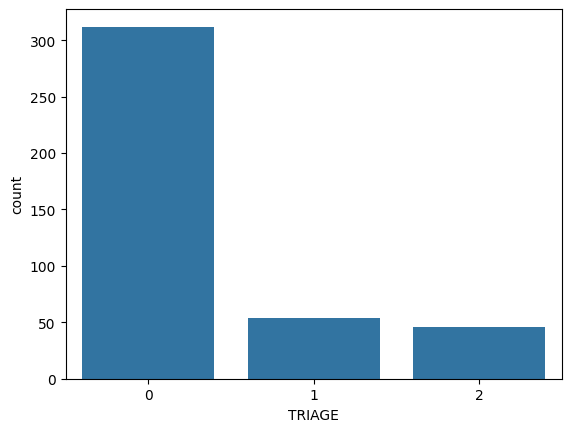

In [7]:
sns.countplot(x=y)
plt.show()

#### Prediction pipe

2025-03-27 19:16:59,297 - SuperClassifier - INFO - Evaluating Baseline...
2025-03-27 19:16:59,297 - SuperClassifier - INFO - Evaluating Baseline...
2025-03-27 19:16:59,298 - SuperClassifier - INFO - Before creating ensemble
2025-03-27 19:16:59,298 - SuperClassifier - INFO - Before creating ensemble
2025-03-27 19:17:01,361 - SuperClassifier - INFO -   CV Score: 0.6741 ± 0.0402
2025-03-27 19:17:01,361 - SuperClassifier - INFO -   CV Score: 0.6741 ± 0.0402
2025-03-27 19:17:01,365 - SuperClassifier - INFO -   Test Score: 0.6893
2025-03-27 19:17:01,365 - SuperClassifier - INFO -   Test Score: 0.6893
2025-03-27 19:17:01,368 - SuperClassifier - INFO - Evaluating Target...
2025-03-27 19:17:01,368 - SuperClassifier - INFO - Evaluating Target...
2025-03-27 19:17:01,370 - SuperClassifier - INFO - Before creating ensemble
2025-03-27 19:17:01,370 - SuperClassifier - INFO - Before creating ensemble
2025-03-27 19:17:01,626 - SuperClassifier - INFO -   CV Score: 0.6737 ± 0.0485
2025-03-27 19:17:01,626

(<__main__.ClassifierEvaluator at 0x74a36dbaa5a0>,
 <Figure size 1200x1500 with 8 Axes>)

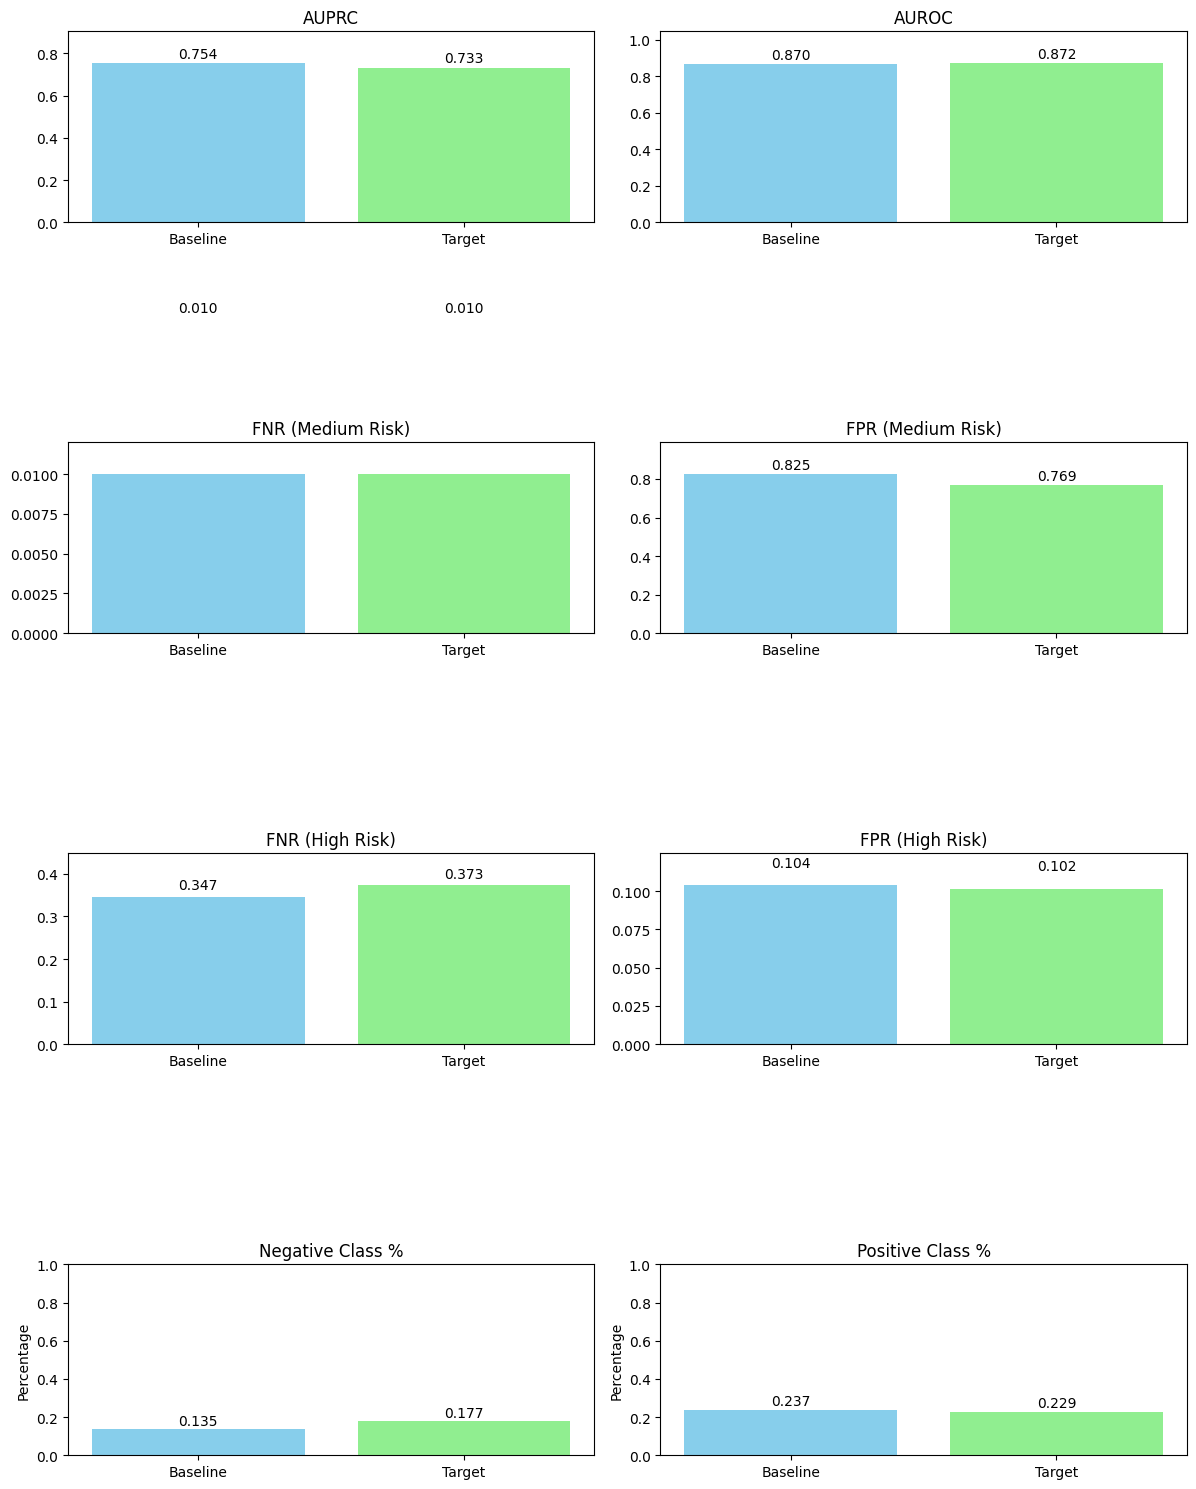

In [8]:
# Setup logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger("ClassifierEvaluation")


class ClassifierEvaluator:
    def __init__(self, random_state=RANDOM_STATE):
        self.random_state = random_state
        self.results = {
            "baseline": {
                "auprc": [],
                "auroc": [],
                "fnr_medium": [],
                "fpr_medium": [],
                "fnr_high": [],
                "fpr_high": [],
                "neg_percent": [],
                "pos_percent": [],
            },
            "target": {
                "auprc": [],
                "auroc": [],
                "fnr_medium": [],
                "fpr_medium": [],
                "fnr_high": [],
                "fpr_high": [],
                "neg_percent": [],
                "pos_percent": [],
            },
        }

    def _find_threshold(
        self, y_true, y_scores, criterion="sensitivity", target_value=0.99
    ):
        """Find threshold based on sensitivity or specificity target."""
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        if criterion == "sensitivity":
            # Find threshold where sensitivity (TPR) >= target_value
            valid_indices = np.where(tpr >= target_value)[0]
            if len(valid_indices) > 0:
                # Get the smallest threshold that meets the criterion
                idx = valid_indices[0]
                return thresholds[idx]
            else:
                # If no threshold meets the criterion, return minimum threshold
                return min(thresholds)
        elif criterion == "specificity":
            # Find threshold where specificity (1-FPR) >= target_value
            specificity = 1 - fpr
            valid_indices = np.where(specificity >= target_value)[0]
            if len(valid_indices) > 0:
                # Get the largest threshold that meets the criterion
                idx = valid_indices[-1]
                return thresholds[idx]
            else:
                # If no threshold meets the criterion, return maximum threshold
                return max(thresholds)

    def _calculate_metrics(
        self, y_true, y_pred_proba, medium_threshold, high_threshold
    ):
        """Calculate FNR, FPR and classification percentages."""
        # Apply thresholds to classify
        y_pred_medium = (y_pred_proba >= medium_threshold).astype(int)
        y_pred_high = (y_pred_proba >= high_threshold).astype(int)

        # For medium risk threshold (sensitivity >= 99%)
        tn_medium = np.sum((y_true == 0) & (y_pred_medium == 0))
        fp_medium = np.sum((y_true == 0) & (y_pred_medium == 1))
        fn_medium = np.sum((y_true == 1) & (y_pred_medium == 0))
        tp_medium = np.sum((y_true == 1) & (y_pred_medium == 1))

        # For high risk threshold (specificity >= 90%)
        tn_high = np.sum((y_true == 0) & (y_pred_high == 0))
        fp_high = np.sum((y_true == 0) & (y_pred_high == 1))
        fn_high = np.sum((y_true == 1) & (y_pred_high == 0))
        tp_high = np.sum((y_true == 1) & (y_pred_high == 1))

        # Calculate FNR and FPR
        fnr_medium = (
            fn_medium / (fn_medium + tp_medium) if (fn_medium + tp_medium) > 0 else 0
        )
        fpr_medium = (
            fp_medium / (fp_medium + tn_medium) if (fp_medium + tn_medium) > 0 else 0
        )
        fnr_high = fn_high / (fn_high + tp_high) if (fn_high + tp_high) > 0 else 0
        fpr_high = fp_high / (fp_high + tn_high) if (fp_high + tn_high) > 0 else 0

        # Calculate percentages of examples classified as negative and positive
        y_classified = np.zeros_like(y_true, dtype=int) - 1  # -1 for gray area
        y_classified[y_pred_proba < medium_threshold] = 0  # Negative
        y_classified[y_pred_proba >= high_threshold] = 1  # Positive

        neg_percent = np.mean(y_classified == 0)
        pos_percent = np.mean(y_classified == 1)

        return {
            "fnr_medium": fnr_medium,
            "fpr_medium": fpr_medium,
            "fnr_high": fnr_high,
            "fpr_high": fpr_high,
            "neg_percent": neg_percent,
            "pos_percent": pos_percent,
        }

    def _get_positive_class_proba(self, model, X):
        """Extract probability for the positive class."""
        proba = model.predict_proba(X)
        # For binary classification, return the probability of class 1
        if proba.shape[1] > 1:
            return proba[:, 1]
        # For single class output (rare), return as is
        return proba.ravel()

    def evaluate_with_super_classifier(self, X, y):
        """Evaluate models using SuperClassifier with repeated stratified k-fold cross-validation."""
        from sklearn.model_selection import RepeatedStratifiedKFold

        # Define baseline model config - removed multi_class parameter
        baseline_config = ModelConfig(
            name="Baseline",
            estimator_class="sklearn.linear_model.LogisticRegression",
            params={"random_state": self.random_state, "max_iter": 1000},
            scoring=ScoringConfig(func=roc_auc_score, kwargs={}),
        )

        # Define target model config - removed multi_class parameter
        target_config = ModelConfig(
            name="Target",
            estimator_class="sklearn.pipeline.Pipeline",
            params={
                "steps": [
                    ("scaler", StandardScaler()),
                    (
                        "classifier",
                        LogisticRegression(
                            class_weight="balanced",
                            random_state=self.random_state,
                            max_iter=1000,
                        ),
                    ),
                ]
            },
            scoring=ScoringConfig(func=roc_auc_score, kwargs={}),
        )

        # Create testing config
        testing_config = TestingConfig(
            models=[baseline_config, target_config],
            random_state=self.random_state,
            verbose=True,
        )

        # Create SuperClassifier
        super_clf = SuperClassifier(testing_config)

        # Fit and evaluate models
        super_clf.fit_evaluate(X, y)

        # Perform custom evaluation with repeated stratified k-fold
        rskf = RepeatedStratifiedKFold(
            n_splits=5, n_repeats=3, random_state=self.random_state
        )
        baseline_model = super_clf.trained_models["Baseline"]
        target_model = super_clf.trained_models["Target"]

        for train_idx, test_idx in rskf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Evaluate baseline model - get probability for positive class
            baseline_proba = self._get_positive_class_proba(baseline_model, X_test)

            # Calculate AUROC and AUPRC for baseline
            baseline_auroc = roc_auc_score(y_test, baseline_proba)
            baseline_auprc = average_precision_score(y_test, baseline_proba)

            # Find thresholds on training set for baseline
            baseline_train_proba = self._get_positive_class_proba(
                baseline_model, X_train
            )
            baseline_medium_threshold = self._find_threshold(
                y_train, baseline_train_proba, "sensitivity", 0.99
            )
            baseline_high_threshold = self._find_threshold(
                y_train, baseline_train_proba, "specificity", 0.90
            )

            # Calculate metrics for baseline
            baseline_metrics = self._calculate_metrics(
                y_test,
                baseline_proba,
                baseline_medium_threshold,
                baseline_high_threshold,
            )

            # Store baseline results
            self.results["baseline"]["auprc"].append(baseline_auprc)
            self.results["baseline"]["auroc"].append(baseline_auroc)
            for key, value in baseline_metrics.items():
                self.results["baseline"][key].append(value)

            # Evaluate target model - get probability for positive class
            target_proba = self._get_positive_class_proba(target_model, X_test)

            # Calculate AUROC and AUPRC for target
            target_auroc = roc_auc_score(y_test, target_proba)
            target_auprc = average_precision_score(y_test, target_proba)

            # Find thresholds on training set for target
            target_train_proba = self._get_positive_class_proba(target_model, X_train)
            target_medium_threshold = self._find_threshold(
                y_train, target_train_proba, "sensitivity", 0.99
            )
            target_high_threshold = self._find_threshold(
                y_train, target_train_proba, "specificity", 0.90
            )

            # Calculate metrics for target
            target_metrics = self._calculate_metrics(
                y_test, target_proba, target_medium_threshold, target_high_threshold
            )

            # Store target results
            self.results["target"]["auprc"].append(target_auprc)
            self.results["target"]["auroc"].append(target_auroc)
            for key, value in target_metrics.items():
                self.results["target"][key].append(value)

        return super_clf

    def get_summary(self) -> Dict[str, Dict[str, float]]:
        """Calculate average metrics across all iterations."""
        summary = {}
        for model_name in ["baseline", "target"]:
            summary[model_name] = {}
            for metric in self.results[model_name]:
                summary[model_name][metric] = np.mean(self.results[model_name][metric])
        return summary

    def plot_results(self, figsize=(12, 15)):
        """Plot comparison of baseline and target models."""
        summary = self.get_summary()
        metrics = [
            ("auprc", "AUPRC"),
            ("auroc", "AUROC"),
            ("fnr_medium", "FNR (Medium Risk)"),
            ("fpr_medium", "FPR (Medium Risk)"),
            ("fnr_high", "FNR (High Risk)"),
            ("fpr_high", "FPR (High Risk)"),
            ("neg_percent", "Negative Class %"),
            ("pos_percent", "Positive Class %"),
        ]

        fig, axes = plt.subplots(4, 2, figsize=figsize)
        axes = axes.flatten()

        for i, (metric_key, metric_name) in enumerate(metrics):
            baseline_val = summary["baseline"][metric_key]
            target_val = summary["target"][metric_key]

            ax = axes[i]
            bars = ax.bar(
                ["Baseline", "Target"],
                [baseline_val, target_val],
                color=["skyblue", "lightgreen"],
            )

            # Add value labels on top of bars
            for bar in bars:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height + 0.01,
                    f"{height:.3f}",
                    ha="center",
                    va="bottom",
                )

            ax.set_title(metric_name)
            ax.set_ylim(0, min(1.1, max(baseline_val, target_val) * 1.2))

            # For percentages, adjust y-axis to show up to 100%
            if "percent" in metric_key:
                ax.set_ylim(0, 1.0)
                ax.set_ylabel("Percentage")
                # Format y-ticks as percentages
                # ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])

        plt.tight_layout()
        return fig


def binarize_decision_class(y, positive_classes=[1, 2]):  # discretize the class
    if isinstance(y, pd.Series):
        return y.isin(positive_classes).astype(int)
    else:
        return pd.Series(np.isin(y, positive_classes).astype(int))


def main(X, y):
    y_binary = binarize_decision_class(y)

    evaluator = ClassifierEvaluator(random_state=RANDOM_STATE)
    super_clf = evaluator.evaluate_with_super_classifier(X, y_binary)
    summary = evaluator.get_summary()

    logger.info("Evaluation Results Summary:")
    for model_name, metrics in summary.items():
        logger.info(f"\n{model_name.upper()} MODEL:")
        for metric_name, value in metrics.items():
            logger.info(f" {metric_name}: {value:.4f}")

    fig = evaluator.plot_results()
    plt.savefig("evaluation_results.png")
    logger.info("Results plot saved as 'evaluation_results.png'")

    return evaluator, super_clf, fig


main(X, y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(random_state=RANDOM_STATE)),
    ]
)
pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)

accuracy = pipeline.score(X_test, y_test)

print(
    classification_report(
        y_test,
        pipeline.predict(X_test),
        target_names=["DISCHARGE", "XRAY", "LAB_XRAY_BSCAN"],
    )
)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
print(f"ROC AUC: {roc_auc:.4f}")

average_precision_score = average_precision_score(
    y_test, y_pred_proba, average="weighted"
)
print(f"Average Precision Score: {average_precision_score:.4f}")

                precision    recall  f1-score   support

     DISCHARGE       0.82      0.85      0.83        62
          XRAY       0.44      0.40      0.42        10
LAB_XRAY_BSCAN       0.44      0.36      0.40        11

      accuracy                           0.73        83
     macro avg       0.57      0.54      0.55        83
  weighted avg       0.72      0.73      0.73        83

ROC AUC: 0.7510
Average Precision Score: 0.7734
